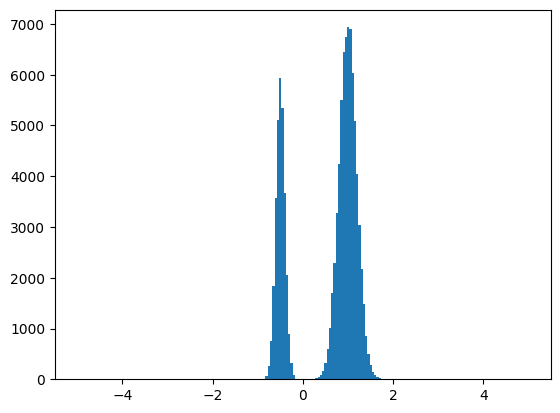

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D

mixture = D.MixtureSameFamily(
    D.Categorical(torch.tensor([0.3, 0.7])),
    D.Normal(torch.tensor([-0.5, 1.0]), torch.tensor([0.1, 0.2])),
)
# target distribution
X = mixture.sample((100000, 1))

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

In [2]:
import torch
import torch.nn as nn


class Backbone(nn.Module):
    def __init__(self, dim: int = 1, layers: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 2, 64),
            *[
                submodule
                for _ in range(layers)
                for submodule in (nn.ReLU(), nn.Linear(64, 64))
            ],
            nn.ReLU(),
            nn.Linear(64, dim),
        )

    def forward(
        self, x_t: torch.Tensor, t: torch.Tensor, delta_t: torch.Tensor | None = None
    ) -> torch.Tensor:
        if delta_t is None:
            delta_t = t
        return self.net.forward(
            torch.cat([x_t, t[:, None].to(x_t), delta_t[:, None].to(x_t)], dim=-1)
        )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

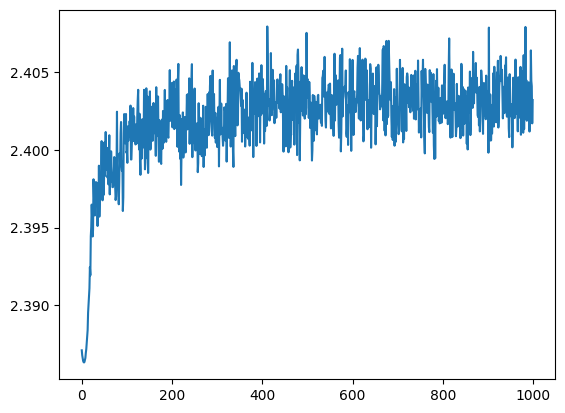

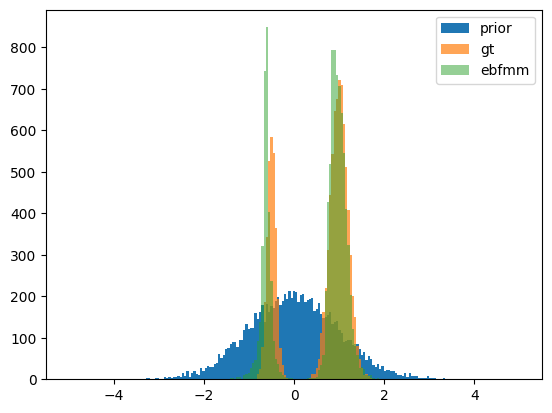

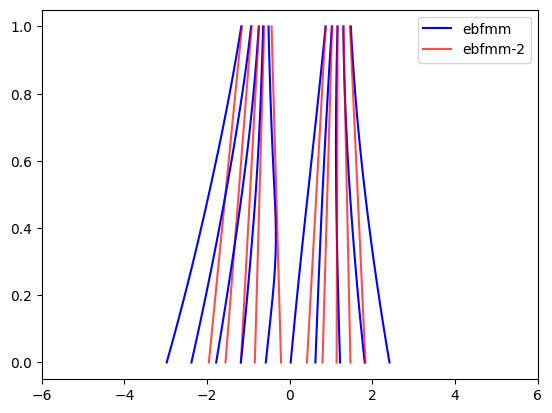

In [3]:
import torch
from tqdm.auto import tqdm

from flowmodels.ebfmm import EBFMM

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048
MU = 0.0

# train
model = EBFMM(Backbone())
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        loss = model.loss(
            sample=X[torch.randint(0, len(X), (BATCH_SIZE,))],
        )
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)

# plot histogram
n = 10000
sample = torch.randn(n, X.shape[-1])
with torch.inference_mode():
    x_t, _ = model.sample(sample, verbose=lambda x: tqdm(x, leave=False), steps=100)

plt.figure()
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="ebfmm", alpha=0.5)
plt.legend()
_xticks, _ = plt.xticks()

# plot trajectory
n = 200
with torch.inference_mode():
    _, x_ts = model.sample(torch.linspace(-3, 3, n)[:, None], steps=100)
    _, x_2s = model.sample(torch.linspace(-3, 3, n)[:, None], steps=2)

plt.figure()
for i in range(10):
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]),
        np.linspace(0, 1, len(x_ts)),
        "b",
        **({} if i > 0 else {"label": "ebfmm"}),  # labeling on first plot only
    )
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_2s]),
        np.linspace(0, 1, len(x_2s)),
        "r",
        alpha=0.7,
        **({} if i > 0 else {"label": "ebfmm-2"}),  # labeling on first plot only
    )
    plt.xticks(_xticks)
plt.legend()